<a href="https://colab.research.google.com/github/aramsargsiann/Portfolio_2024/blob/main/Diffusion_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**new code era**

**1**

In [ ]:
from google.colab import files
files.upload()

Saving diffusion_model_classes.py to diffusion_model_classes.py


{'diffusion_model_classes.py': b'# -*- coding: utf-8 -*-\n"""Diffusion_Model_Classes.ipynb\n\nAutomatically generated by Colab.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1VFUPUchJkf5SjoPpBqpWw9Mh2M_0Ogxi\n"""\n\n# lybrires\n\nfrom tqdm import tqdm\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\nfrom IPython.display import HTML\nfrom typing import Dict, Tuple\nfrom torchvision import models, transforms\nfrom torchvision.utils import save_image, make_grid\nimport matplotlib.pyplot as plt\nfrom matplotlib.animation import FuncAnimation, PillowWriter\nimport numpy as np\nfrom torchvision import datasets, transforms\nfrom torch.utils.data import DataLoader, random_split\nimport torch\nimport torchvision.models as models\nimport torchvision.transforms as transforms\nfrom torchvision.datasets import MNIST\nfrom torchvision.transforms import Grayscale\n\ndef space_to_depth(x, size=2):\n    """\n    Downsacle method that use the depth dim

In [1]:
# lybrires

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import HTML
from typing import Dict, Tuple
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.transforms import Grayscale

In [2]:
# MNIST Dataset transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet18 input size
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images
])

# Load MNIST Dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load pre-trained ResNet18 model for embeddings
pretrained_model = models.resnet18(pretrained=True)
pretrained_model = nn.Sequential(*list(pretrained_model.children())[:-1])  # Remove last classification layer

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 43191146.51it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2957053.43it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 11471822.43it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2837010.99it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 35.2MB/s]


In [ ]:
# this code saves embadigns for MNIST data set
labels = []
for images, targets in train_loader:
    with torch.no_grad():
        features = pretrained_model(images)
        labels.append(features.view(features.size(0), -1))  # Flatten the embeddings

# Concatenate embeddings and convert to tensor
labels = torch.cat(labels, dim=0)

# Save the labels (embeddings) to a file
torch.save(labels, 'mnist_labels.pth')

TypeError: Invalid shape (3, 224, 224) for image data

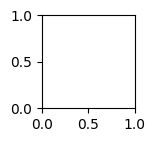

In [ ]:
# Visualize some sample images from the training set
plt.figure(figsize=(7, 7))
for i in range(25):
    image, label = train_dataset[i]
    plt.subplot(5, 5, i + 1)
    plt.imshow(image.squeeze().numpy(), cmap='gray')  # Convert tensor to numpy array and remove the channel dimension
    plt.title("Label: " + str(label))
    plt.axis('off')
plt.show()

In [ ]:
from diffusion_model_classes import SpaceToDepth, SinusodialPositionEmbedding, ResnetBlock, Residual, PreGroupNorm,
LinearAttention, downsample, Attention, upsample



---



In [ ]:
class DiffusionUnet(nn.Module):
  def __init__(self, dim, init_dim=None, output_dim=None, dim_mults=(1, 2, 4, 8), channels=3, resnet_block_groups=4):
    super().__init__()

    self.channels = channels
    init_dim = init_dim if init_dim is not None else dim
    self.init_conv = nn.Conv2d(self.channels, init_dim, 1)
    dims = [init_dim] + [m * dim for m in dim_mults]
    input_output_dims = list(zip(dims[:-1], dims[1:]))

    time_dim = 4 * dim  # time embedding

    self.time_mlp = nn.Sequential(
        SinusodialPositionEmbedding(dim),
        nn.Linear(dim, time_dim),
        nn.GELU(),
        nn.Linear(time_dim, time_dim)
    )

    # down layers
    self.down_layers = nn.ModuleList([])
    for ii, (dim_in, dim_out) in enumerate(input_output_dims, 1):
      is_last = ii == len(input_output_dims)
      self.down_layers.append(
          nn.ModuleList(
              [
                  ResnetBlock(dim_in, dim_in, time_emb_dim=time_dim, groups=resnet_block_groups),
                  ResnetBlock(dim_in, dim_in, time_emb_dim=time_dim, groups=resnet_block_groups),
                  Residual(PreGroupNorm(dim_in, LinearAttention(dim_in))),
                  downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding=1)
              ]
          )
      )

      # middle layers
      mid_dim = dims[-1]
      self.mid_block1 = ResnetBlock(mid_dim, mid_dim, time_emb_dim=time_dim, groups=resnet_block_groups)
      self.mid_attention = Residual(PreGroupNorm(mid_dim, Attention(mid_dim)))
      self.mid_block2 = ResnetBlock(mid_dim, mid_dim, time_emb_dim=time_dim, groups=resnet_block_groups)

      # up layers
      self.up_layers = nn.ModuleList([])
      for ii, (dim_in, dim_out) in enumerate(reversed(input_output_dims), 1):
        is_last = ii == len(input_output_dims)
        self.up_layers.append(
            nn.ModuleList(
                [
                    ResnetBlock(dim_out + dim_in, dim_out, time_emb_dim=time_dim, groups=resnet_block_groups),
                    ResnetBlock(dim_out + dim_in, dim_out, time_emb_dim=time_dim, groups=resnet_block_groups),
                    Residual(PreGroupNorm(dim_out, LinearAttention(dim_out))),
                    upsample(dim_out, dim_in) if not is_last else nn.Conv2d(dim_out, dim_in, 3, padding=1)
                ]
            )
        )

        self.output_dim = output_dim if output_dim is not None else channels
        self.final_res_block = ResnetBlock(2 * dim, dim, time_emb_dim=time_dim, groups=resnet_block_groups)
        self.final_conv = nn.Conv2d(dim, self.output_dim, 1)

  def forward(self, x, time):
    x = self.init_conv(x)
    init_result = x.clone()
    t = self.time_mlp(time)
    h = []

    for block1, block2, attention, downsample_block in self.down_layers:
      x = block1(x, t)
      h.append(x)

      x = block2(x, t)
      x = attention(x)

      h.append(x)

      x = downsample_block(x)

    x = self.mid_block1(x, t)
    x = self.mid_attention(x)
    x = self.mid_block2(x ,t)

    for block1, block2, attention, upsample_block in self.up_layers:
      x = torch.cat((x , h.pop()), dim=1)
      x = block1(x, t)

      x = torch.cat((x, h.pop()), dim=1)
      x = block2(x, t)

      x = attention(x)

      x = upsample_block(x)

    x = torch.cat((x, init_result), dim=1)
    x = self.final_res_block(x, t)
    x = self.final_conv(x)
    return x

**2**

In [ ]:
# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 28 # 16x16 image
save_dir = './weights/'

# training hyperparameters
batch_size = 100
n_epoch = 32
lrate=1e-3

# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()
ab_t[0] = 1

**3**

In [ ]:
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

In [ ]:
def perturb_input(x, t, noise):
    return ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise

**4**

In [ ]:
# training with context code
# set into train mode
nn_model.train()

for ep in range(n_epoch):
    print(f'epoch {ep}')

    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

    pbar = tqdm(dataloader, mininterval=2 )
    for x, c in pbar:   # x: images  c: context
        optim.zero_grad()
        x = x.to(device)
        c = c.to(x)

        # randomly mask out c
        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
        c = c * context_mask.unsqueeze(-1)

        # perturb data
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device)
        x_pert = perturb_input(x, t, noise)

        # use network to recover noise
        pred_noise = nn_model(x_pert, t / timesteps, c=c)

        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        loss.backward()

        optim.step()

      # save model periodically
    if ep%4==0 or ep == int(n_epoch-1):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save(nn_model.state_dict(), save_dir + f"context_model_{ep}.pth")
        print('saved model at ' + save_dir + f"context_model_{ep}.pth")

In [ ]:
# load in pretrain model weights and set to eval mode
# u can also not to run
nn_model.load_state_dict(torch.load(f"{save_dir}/context_model_trained.pth", map_location=device))
nn_model.eval()
print("Loaded in Context Model")

**5**

In [ ]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

**6**

In [ ]:
# define sampling function for DDIM
# removes the noise using ddim
def denoise_ddim(x, t, t_prev, pred_noise):
    ab = ab_t[t]
    ab_prev = ab_t[t_prev]

    x0_pred = ab_prev.sqrt() / ab.sqrt() * (x - (1 - ab).sqrt() * pred_noise)
    dir_xt = (1 - ab_prev).sqrt() * pred_noise

    return x0_pred + dir_xt

**7**

In [ ]:
# fast sampling algorithm with context
@torch.no_grad()
def sample_ddim_context(n_sample, context, n=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)

    # array to keep track of generated steps for plotting
    intermediate = []
    step_size = timesteps // n
    for i in range(timesteps, 0, -step_size):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        eps = nn_model(samples, t, c=context)    # predict noise e_(x_t,t)
        samples = denoise_ddim(samples, i, i - step_size, eps)
        intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

**8**

In [ ]:
# visualize samples
plt.clf()
ctx = F.one_hot(torch.randint(0, 5, (32,)), 5).to(device=device).float()
samples, intermediate = sample_ddim_context(32, ctx)
animation_ddpm_context = plot_sample(intermediate,32,4,save_dir, "ani_run", None, save=False)
HTML(animation_ddpm_context.to_jshtml())